#Tiktok Video Classification using ML

Data source - Coursera (Google Advanced Data Analytics)

The **purpose** of this model is to mitigate misinformation in videos on the TikTok platform.

The **goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [ ]:
# Import Dataset
data = pd.read_csv("drive/My Drive/Colab Notebooks/tiktok_dataset.csv")

In [ ]:
data.head(2)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0


In [ ]:
data.columns

Index(['#', 'claim_status', 'video_id', 'video_duration_sec',
       'video_transcription_text', 'verified_status', 'author_ban_status',
       'video_view_count', 'video_like_count', 'video_share_count',
       'video_download_count', 'video_comment_count'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [ ]:
data.shape

(19382, 12)

In [ ]:
# Any null entries?
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

The data has a few of empty entries compared to the entire dataset Hence we can drop those entires from the data.

In [ ]:
data = data.dropna(axis=0)

In [ ]:
data.duplicated().sum() # Check for any duplicate entries

0

In [ ]:
# Percent classes
data['claim_status'].value_counts(normalize=True)*100

claim      50.345839
opinion    49.654161
Name: claim_status, dtype: float64

The data is well baalnced.

In [ ]:
# Feature Engineering

In [ ]:
# Converting the video transcription text string to length of the text.
data['text_length'] = data['video_transcription_text'].str.len()
data.head(2)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107


In [ ]:
# Average text length per each class.
data[['claim_status','text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


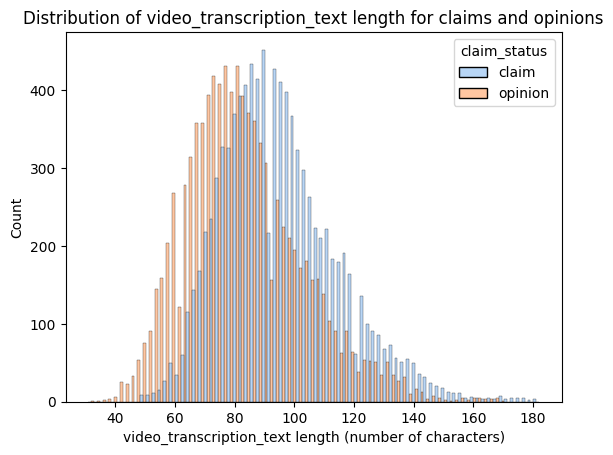

In [ ]:
sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

In [ ]:
# Feature selection

X = data.drop(columns=['#','video_id'])
X.claim_status = [1 if i == 'claim' else 0 for i in X.claim_status]
X = pd.get_dummies(X,
                   columns=['verified_status','author_ban_status'],
                   drop_first=True)
X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


In [ ]:
# Spliting the Data in X and y
y = X['claim_status']
X = X.drop(columns=['claim_status'])
print(X.shape,y.shape)

(19084, 11) (19084,)


In [ ]:
# Splitting into train and test sets
X_tr, X_test, y_tr, y_test  = train_test_split(X,y, test_size=0.3,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.3,random_state=42)
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(9350, 11) (9350,) (5726, 11) (5726,) (4008, 11) (4008,)


In [ ]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [ ]:
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [ ]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing say,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True),count_df],axis=1)
X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing say,willing wager
0,26,3975.0,1626.0,280.0,36.0,10.0,77,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,38,109453.0,38018.0,13927.0,595.0,170.0,114,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,59,7938.0,1593.0,301.0,23.0,8.0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,6,953784.0,406769.0,57819.0,4102.0,1486.0,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,32,5299.0,1993.0,83.0,15.0,0.0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing say,willing wager
0,15,2865.0,1219.0,62.0,24.0,3.0,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39,211942.0,22320.0,984.0,113.0,55.0,87,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,512046.0,7896.0,2652.0,165.0,47.0,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,52,880947.0,290261.0,49648.0,2920.0,964.0,88,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,50,656510.0,2424.0,208.0,22.0,6.0,103,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
# Test Data

# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,read news,social media,willing say,willing wager
0,22,6517.0,337.0,120.0,5.0,0.0,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,39,758131.0,41367.0,11288.0,774.0,143.0,83,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,17,613559.0,368043.0,113662.0,7130.0,4288.0,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,363966.0,196481.0,1246.0,1593.0,657.0,114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,582955.0,86748.0,7182.0,865.0,21.0,98,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Building Models

#### RF Model

In [ ]:
# Build Model - Random forest Model

rf = RandomForestClassifier(random_state=42)

cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200]
             }
scoring = {'f1','accuracy','precision','recall'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall' )


In [ ]:
%%time
rf_cv.fit(X_train_final, y_train)

CPU times: user 6min 43s, sys: 1.08 s, total: 6min 44s
Wall time: 7min 50s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'recall', 'f1', 'accuracy'})

In [ ]:
rf_cv.best_score_

0.9951257706202707

In [ ]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

#### XGBoost Classifier

In [ ]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [ ]:
%%time
xgb_cv.fit(X_train_final,y_train)

CPU times: user 16min 58s, sys: 3.35 s, total: 17min 2s
Wall time: 11min 56s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'precision', 'recall', 'f1', 'accuracy'})

In [ ]:
xgb_cv.best_score_

0.9921589949134569

In [ ]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 500}

### Evaluating Models

#### RF Model

In [ ]:
# Evaluate Models

y_pred = rf_cv.best_estimator_.predict(X_val_final)
y_pred.shape

(4008,)

In [ ]:
print("Precision score = ",precision_score(y_val, y_pred))
print("Accuracy score = ",accuracy_score(y_val,y_pred))
print("Recall score = ", recall_score(y_val,y_pred))
print("f1 score = ", f1_score(y_val,y_pred))

Precision score =  1.0
Accuracy score =  0.9975049900199601
Recall score =  0.995049504950495
f1 score =  0.9975186104218362


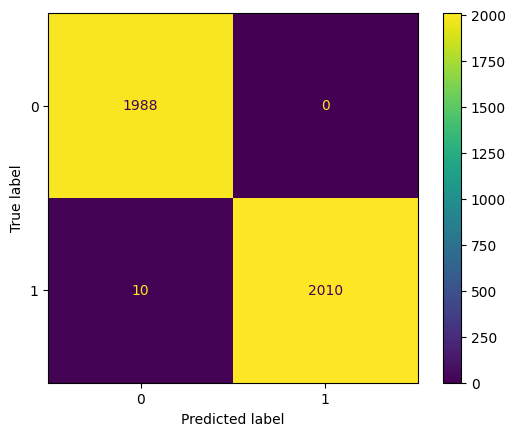

In [ ]:
# Confusion Matrix - RF model

cm = confusion_matrix(y_val,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = None)
disp.plot()

plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1988
       claim       1.00      1.00      1.00      2020

    accuracy                           1.00      4008
   macro avg       1.00      1.00      1.00      4008
weighted avg       1.00      1.00      1.00      4008



#### XGBoost

In [ ]:
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

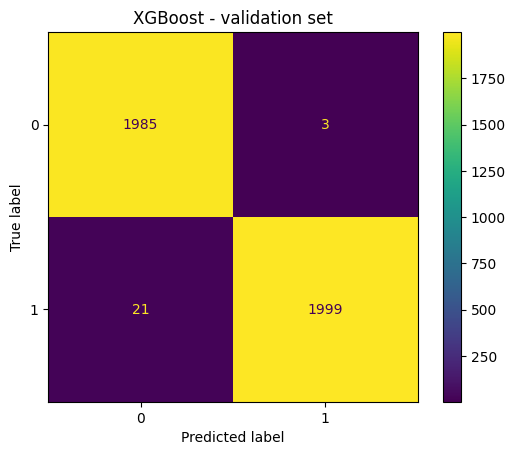

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

plt.title('XGBoost - validation set');
# Display plot
plt.show()


In [ ]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1988
       claim       1.00      0.99      0.99      2020

    accuracy                           0.99      4008
   macro avg       0.99      0.99      0.99      4008
weighted avg       0.99      0.99      0.99      4008



### Prediction on Test data

In [ ]:
y_pred = rf_cv.best_estimator_.predict(X_test_final)

In [ ]:
print("Precision score = ",precision_score(y_test, y_pred))
print("Accuracy score = ",accuracy_score(y_test,y_pred))
print("Recall score = ", recall_score(y_test,y_pred))
print("f1 score = ", f1_score(y_test,y_pred))

Precision score =  1.0
Accuracy score =  0.9968564442892072
Recall score =  0.9937260369466713
f1 score =  0.9968531468531469


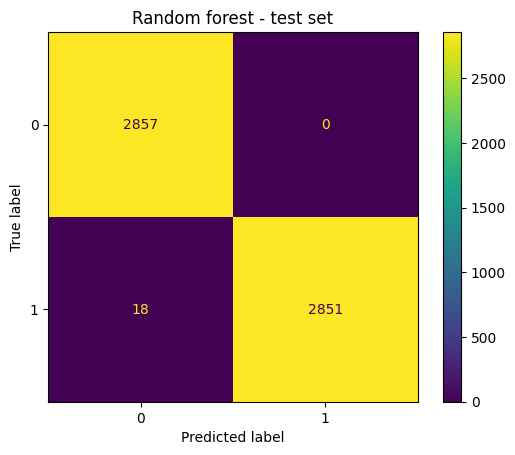

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()
plt.title('Random forest - test set');
# Display plot
plt.show()


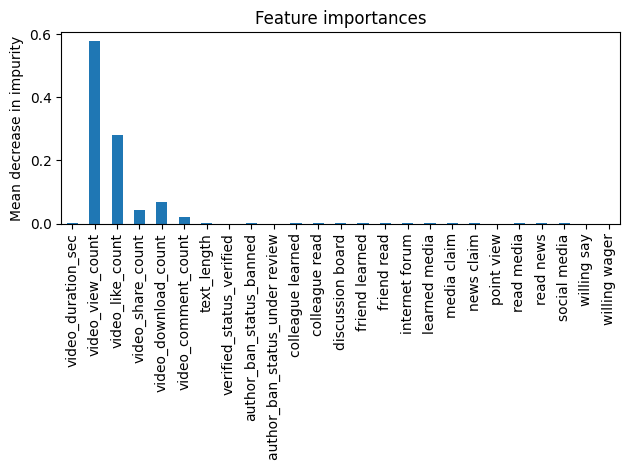

In [ ]:
# Feature Importance

importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()